# Hourly Energy Consumption Forecasting


### Time series forecasting with XGBoost in Python

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Note: The regions have changed over the years so data may only appear for certain dates per region.


___

**Imports**

In [1]:
# Data 
import pandas as pd
import numpy as np

# Modeling
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color_pal = sns.color_palette()

**Read Data**

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')  # PJM East data
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


<Axes: title={'center': 'PJME Energy Use in Megawatts'}, xlabel='Datetime'>

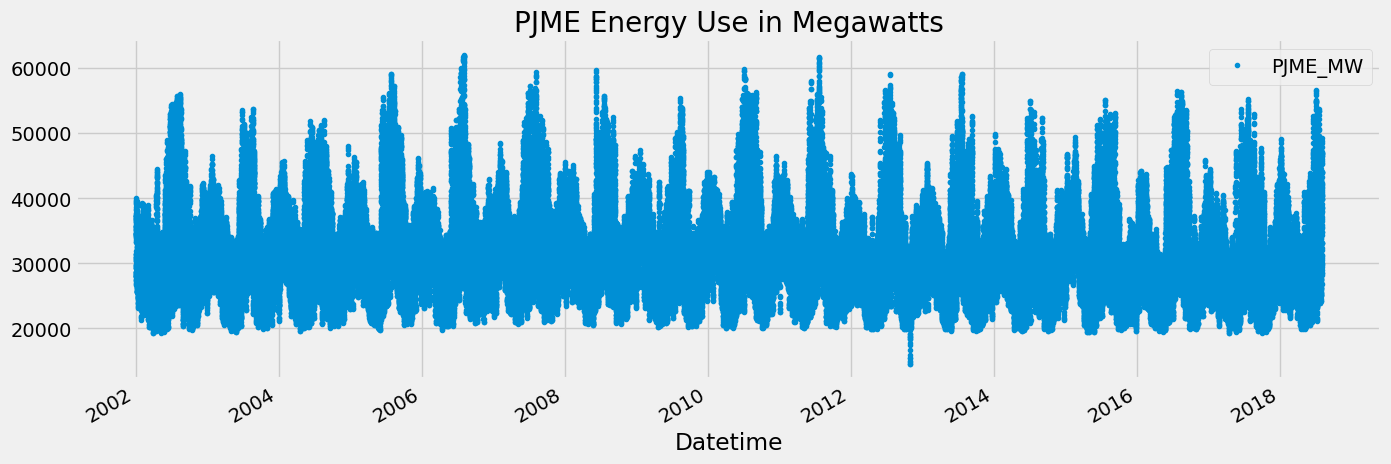

In [5]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy Use in Megawatts")

**Train/Test Split**

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

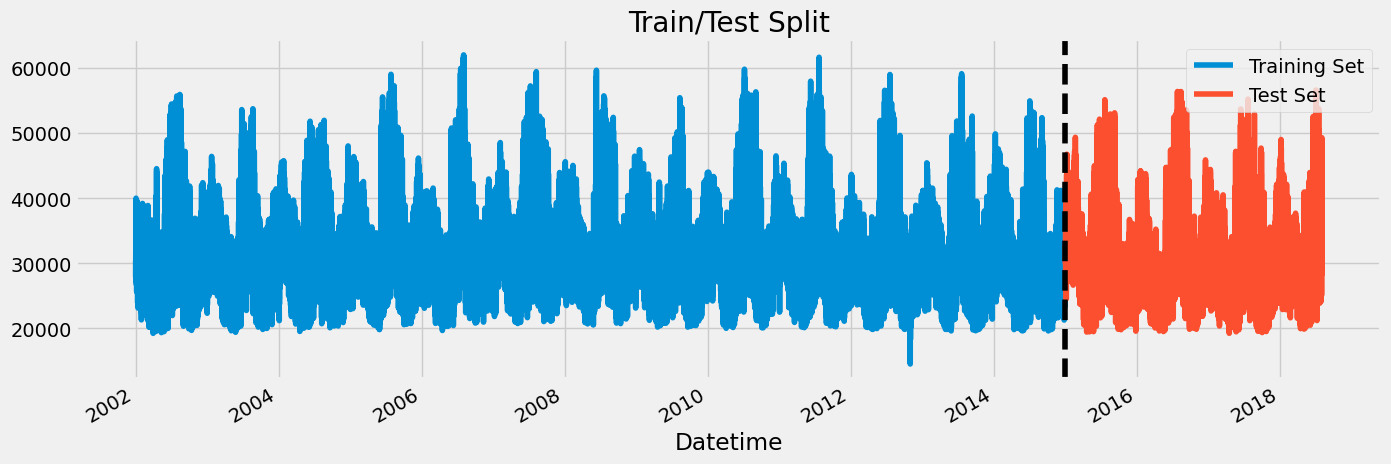

In [7]:
fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set', title='Train/Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


Explore a single week of data

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

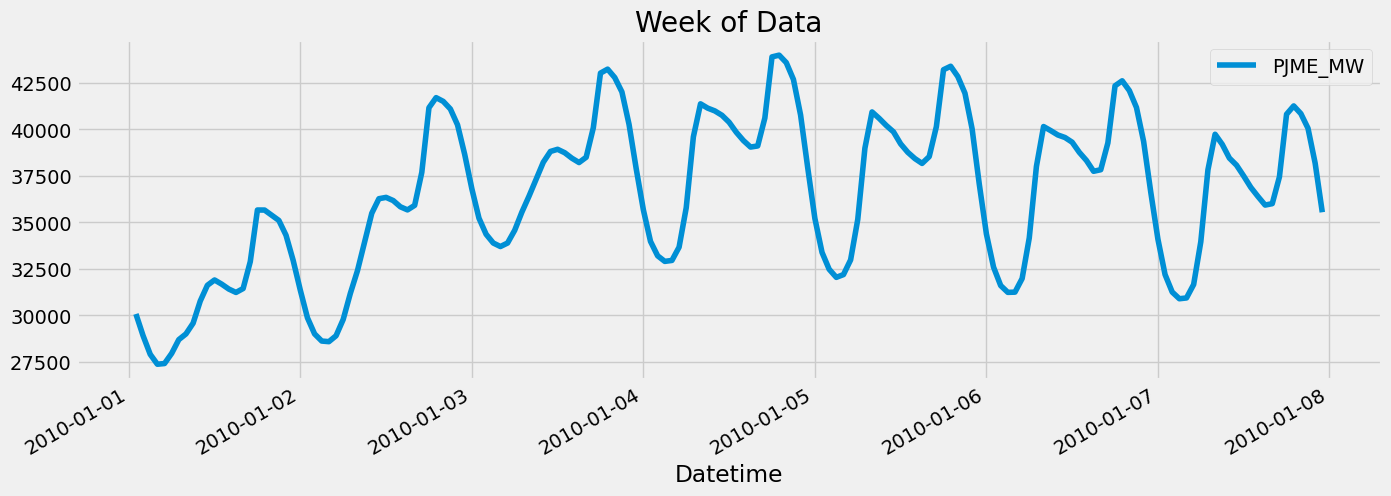

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),
                                                                   title='Week of Data')

**Feature Creation**

In [9]:
def create_features(df):
    """
    Creat time series features based on time series index
    """
    df = df.copy()  # Ensure we are editing a copy
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['day_of_year'] = df.index.dayofyear
    df['year'] = df.index.year

    return df


In [10]:
df = create_features(df)

**Visualize Feature/Target Relationsip**

Boxplot

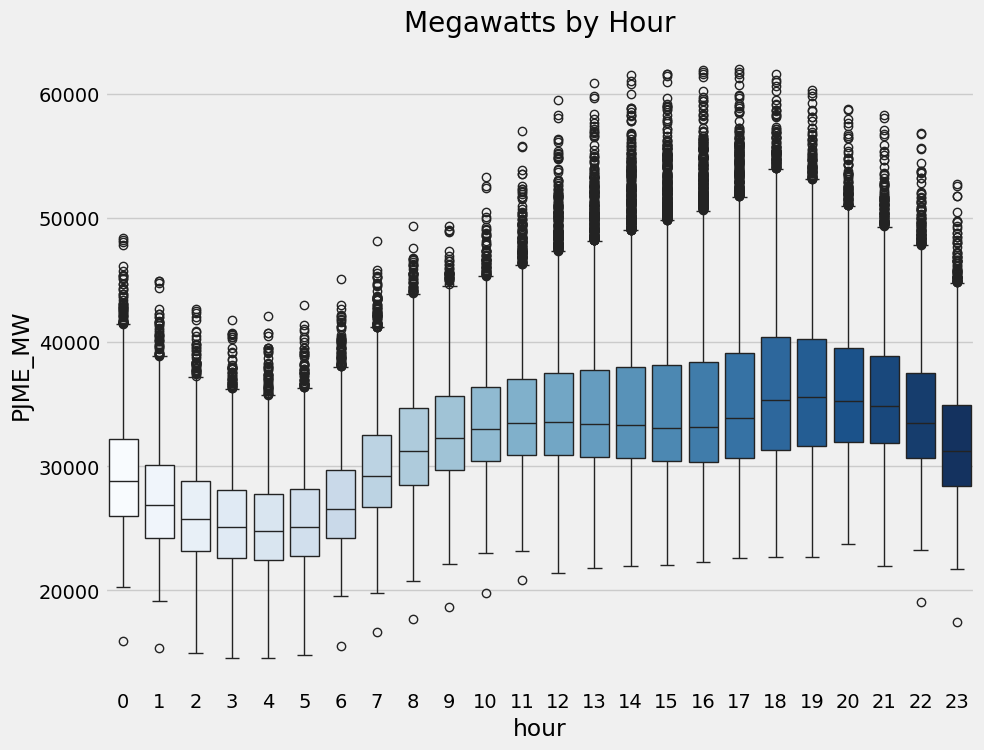

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Blues', hue='hour', legend=False)
ax.set_title('Megawatts by Hour')
plt.show()

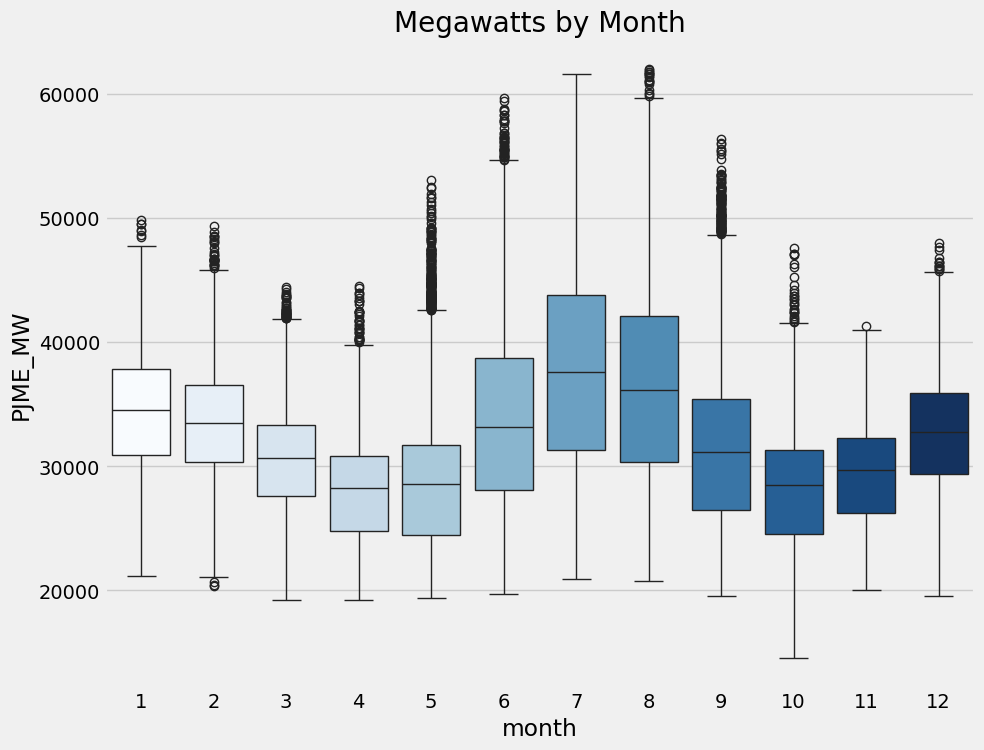

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues', hue='month', legend=False)
ax.set_title('Megawatts by Month')
plt.show()

We can see that megawatt usage peaks in the winter and mid summer while being lower in the fall and spring seasons. This is expected as people run their ac units more during colder/hotter months.

**Model Creation**

This is a regression task so we will use XGBoost Regressor

In [27]:
train = create_features(train)  
test = create_features(test)

features = [col for col in df.columns]
features.remove('PJME_MW')
target = 'PJME_MW'

In [28]:
# Train set
X_train, y_train = train[features], train[target]

# Test set
X_test, y_test = test[features], test[target]

In [29]:
model_1 = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,       # Stop early if test set does not improve after 50 trees
                       learning_rate=0.01) 

model_1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=100)


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Check Feature Importance**

In [33]:
f_imp = pd.DataFrame(data=model_1.feature_importances_,
             index=model_1.feature_names_in_,
             columns=['importance'])

f_imp

,importance
hour,0.495674
day_of_week,0.173109
month,0.179404
quarter,0.000000
day_of_year,0.126356
year,0.025457


<Axes: title={'center': 'Feature Importance'}>

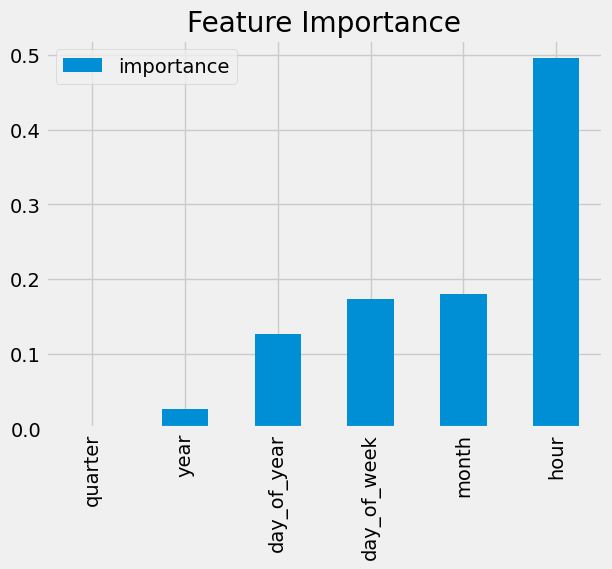

In [35]:
f_imp.sort_values('importance').plot(kind='bar', title='Feature Importance')

These features are highly correlated so we cant expect this feature importance functionality won't really tell us how important each feature is individually, but provides a decent overview

**Forecast on Test Data**

In [37]:
test['prediction'] = model_1.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

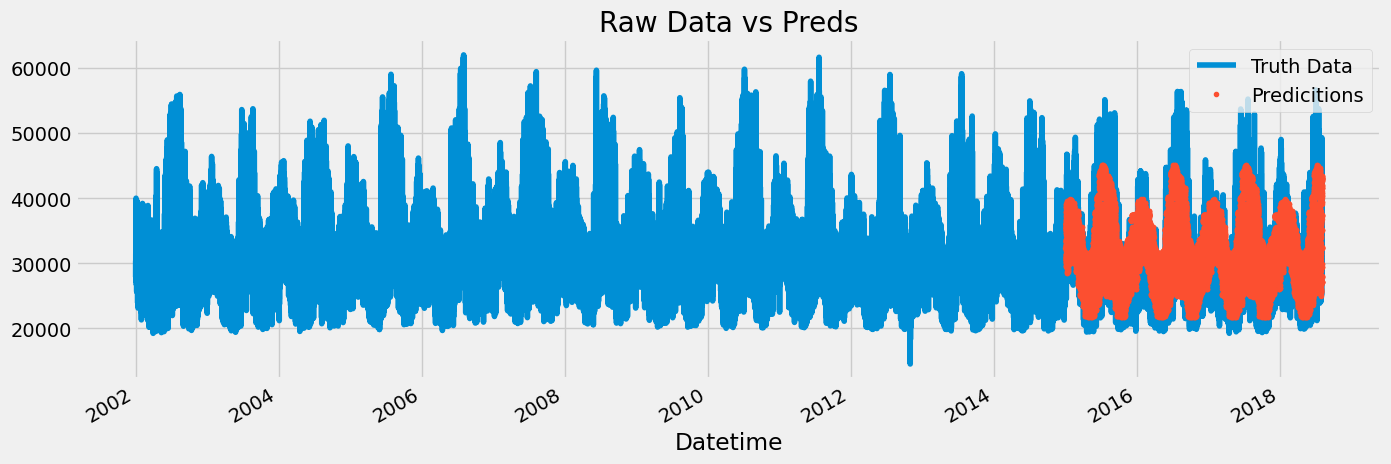

In [39]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predicitions'])
ax.set_title('Raw Data vs Preds')
plt.show()


1 week of predicitons

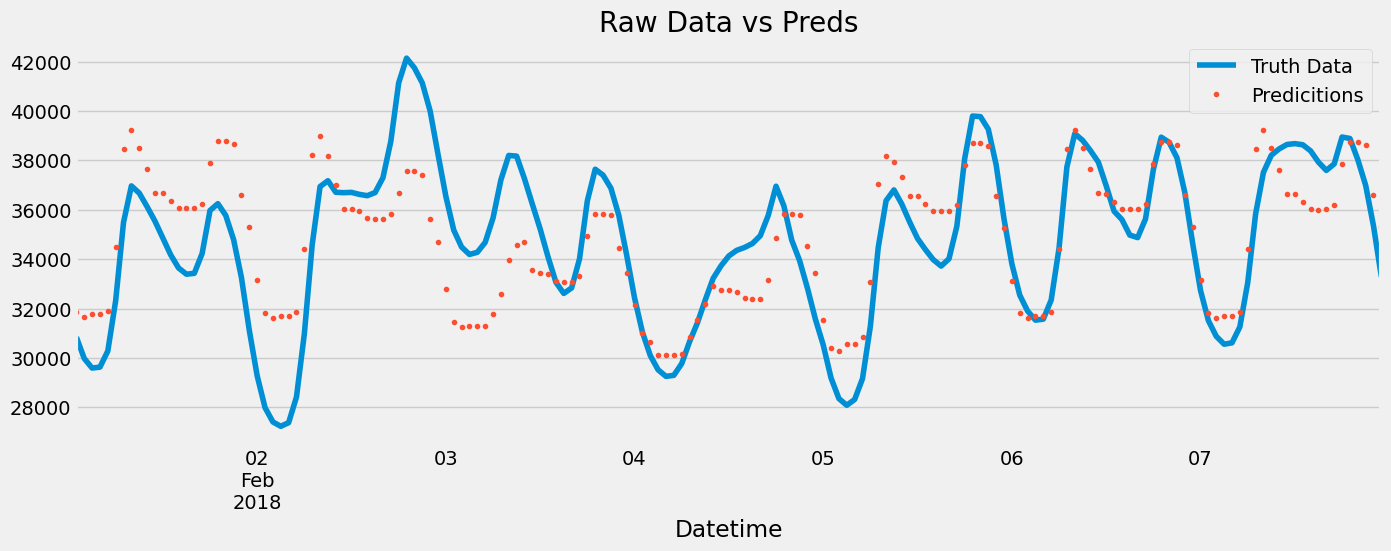

In [40]:
# Truth Data vs Preds for 1st week of February 2018 (has to be 2018 because that year must include test data)
ax = df.loc[(df.index > '02-01-2018') & (df.index < '02-08-2018')]['PJME_MW'].plot(figsize=(15,5),
                                                                                   title= '1 Week of Data')
df.loc[(df.index > '02-01-2018') & (df.index < '02-08-2018')]['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predicitions'])
ax.set_title('Raw Data vs Preds')
plt.show()

In [44]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

print(f"RMSE score on Test set: {score:0.2f}")

RMSE score on Test set: 3741.03


Best / Worst predicitions

In [49]:
# General error value for each pred
test['error'] = np.abs(test[target] - test['prediction'])

test['date'] = test.index.date
# Average error
best = test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)
worst = test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)


best, worst

(date
 2016-12-30    395.436442
 2017-10-24    413.885824
 2016-10-27    440.053141
 2016-04-04    440.223877
 2017-05-02    453.738688
 2015-10-28    459.086426
 2016-06-03    467.453532
 2018-02-06    477.327718
 2016-08-08    496.441406
 2016-12-12    553.641357
 Name: error, dtype: float64,
 date
 2016-08-13    13829.866211
 2016-08-14    13577.304362
 2016-09-10    11235.855143
 2016-09-09    11032.220215
 2016-08-12    10667.820312
 2018-01-06    10407.698161
 2015-02-20    10143.611491
 2017-05-19     9495.122640
 2016-07-04     9440.610596
 2016-07-23     9362.332682
 Name: error, dtype: float64)

This first model does ok but clearly needs a lot of improvement. Avenues include:
* Parameter tuning
* Add more features (ex. weather forecast, holidays)